In [1]:
import mdtraj as md
import mdfeature.features as features
import numpy as np
import dill
from mdfeature.ConvergenceAnalyser import free_energy_estimate_2D
import pyemma
from mdfeature.KramersRateEvaluator import KramersRateEvaluator
import pydiffmap.diffusion_map as dfm
from time import time

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2
font = {'family' : 'sans-serif',
        'size'   : 14.0}
mpl.rc('font', **font) 
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] =  16
mpl.rcParams['font.size'] =  15
mpl.rcParams['figure.autolayout'] =  True
mpl.rcParams['figure.figsize'] =  7.2,4.45
mpl.rcParams['axes.titlesize'] =  16
mpl.rcParams['axes.labelsize'] =  17
mpl.rcParams['lines.linewidth'] =  2
mpl.rcParams['lines.markersize'] =  6
mpl.rcParams['legend.fontsize'] =  13

Define Experiment Class

In [3]:
import openmm.unit as unit

unit_labels = {
    "us": unit.microseconds,
    "ns": unit.nanoseconds,
    "ps": unit.picoseconds,
    "fs": unit.femtoseconds
}


def parse_quantity(s):
    try:
        u = s.lstrip('0123456789.')
        v = s[:-len(u)]
        return unit.Quantity(
            float(v),
            unit_labels[u]
        )
    except Exception:
        raise ValueError(f"Invalid quantity: {s}")
        
def subsample_trajectory(trajectory, stride):
    traj = md.Trajectory(trajectory.xyz[::stride], trajectory.topology)
    return traj.superpose(traj[0]) 

def check_and_remove_nans(data, axis=1):
    num_nans = np.count_nonzero(np.isnan(data)) 
    if num_nans > 0:
        axis_str = "rows" if axis==1 else "columns"
        print(f"{num_nans} NaNs detected, removing {axis_str} with NaNs.")
        data = data[~np.isnan(data).any(axis=1), :]
        
    return data


    
class Experiment:

        def __init__(self, pdb, trajectory, dihedral_pickle_file, temperature, duration, savefreq, stepsize):
            self.pdb, self.topology, self.trajectory, self.dihedral_traj = \
                    self.load_experiment(pdb, trajectory, dihedral_pickle_file)
            self.temperature = temperature
            self.duration = parse_quantity(duration)
            self.savefreq = parse_quantity(savefreq)
            self.stepsize = parse_quantity(stepsize)
            self.iterations = int(self.duration / self.stepsize)
            self.beta = 1/(self.temperature*0.0083144621)
            self.conformations = len(self.trajectory)

            assert np.abs(self.conformations - int(self.duration/self.savefreq)) <= 1, f"duration ({duration}) and savefreq ({savefreq}) incompatible with number of conformations found in trajectory (got {self.conformations}, expected {int(self.duration/self.savefreq)})."

            self.PCA = None
            self.TICA = None
            self.VAMP = None
            self.kre = KramersRateEvaluator()
            self.kre_params = {'minimum_counts':25,'bins':200,'impute_free_energy_nans':True,
                               'cluster_type':'kmeans','k':100,'ignore_high_energy_minima':False,
                              'include_endpoint_minima':True,'minima_prominence':1.5,'options':None}
            self.dmap = dfm.DiffusionMap.from_sklearn(epsilon = 'bgh', alpha = 0.5, k=64, kernel_type='gaussian', n_evecs=5, neighbor_params=None,
                             metric='euclidean', metric_params=None, weight_fxn=None, density_fxn=None, bandwidth_type="-1/(d+2)",
                             bandwidth_normalize=False, oos='nystroem')

        @staticmethod
        def load_experiment(pdb, trajectory, dihedral_pickle_file):
            pdb_file = md.load_pdb(pdb)
            topology_file = pdb_file.topology
            traj = pyemma.coordinates.load(trajectory, top=topology_file)
            dihedral_traj = np.array(dill.load(open(dihedral_pickle_file, "rb"))).T
            # correcting order
            dihedral_traj[:,[0, 1]] = dihedral_traj[:,[1, 0]]

            return pdb_file, topology_file, traj, dihedral_traj

        def ramachandran_plot(self, bins=100, nan_threshold=50, rotate=False):
            dihedral_traj = check_and_remove_nans(self.dihedral_traj)
            free_energy, xedges, yedges = free_energy_estimate_2D(dihedral_traj, self.beta, bins=bins)
            fig, ax = plt.subplots()
            if rotate is True:
                free_energy = free_energy.T
            im = ax.pcolormesh(xedges, yedges, np.ma.array(free_energy, mask=(free_energy > nan_threshold)))
            plt.colorbar(im)
            plt.xlabel(r'$\phi$')
            plt.ylabel(r'$\psi$')
            plt.gca().set_aspect('equal')
            plt.show()

        def compute_PCA(self, dim, stride=1):
            t0 = time()
            self.PCA = pyemma.coordinates.pca(self.trajectory, dim=dim, stride=stride)
            t1 = time()
            print(f"Computed PCA in {round(t1-t0,3)}s.")

        def compute_TICA(self, dim, lag, stride=1):
            t0 = time()
            self.TICA = pyemma.coordinates.tica(self.trajectory, lag=lag, dim=dim, stride=stride)
            t1 = time()
            print(f"Computed TICA in {round(t1-t0,3)}s.")

        def compute_VAMP(self, dim, lag, stride=1):
            t0 = time()
            self.VAMP = pyemma.coordinates.vamp(self.trajectory, lag=lag, dim=dim, stride=stride)
            t1 = time()
            print(f"Computed VAMP in {round(t1-t0,3)}s.")
                
        def compute_DMAP(self, stride):
            t0 = time()
            self.DMAP = self.dmap.fit(self.trajectory[::stride])
            t1 = time()
            print(f"Computed DMAP in {round(t1-t0,3)}s.")
                
        def analyse_PCA(self, dimension, lag, sigmaD, sigmaF):
            assert self.PCA is not None, "Run compute_PCA before analyse_PCA."
            self.kre.fit(self.PCA.get_output()[0][:,dimension], beta = self.beta, time_step = self.stepsize,
                         lag = lag, sigmaD = sigmaD, sigmaF = sigmaF, **self.kre_params)
            
        def analyse_TICA(self, dimension, lag, sigmaD, sigmaF):
            assert self.TICA is not None, "Run compute_TICA before analyse_TICA."
            self.kre.fit(self.TICA.get_output()[0][:,dimension], beta = self.beta, time_step = self.stepsize, 
                         lag = lag, sigmaD = sigmaD, sigmaF = sigmaF, **self.kre_params)
        
        def analyse_VAMP(self, dimension, lag, sigmaD, sigmaF):
            assert self.VAMP is not None, "Run compute_VAMP before analyse_VAMP."
            self.kre.fit(self.VAMP.get_output()[0][:,dimension], beta = self.beta, time_step = self.stepsize, 
                         lag = lag, sigmaD = sigmaD, sigmaF = sigmaF, **self.kre_params)
        



Tasks to do

2) TICA with and without Dihedral Featurizer
3) OpenMM metadynamics - in what form do the collective variables need to be given?
5) Diffusion maps vs. TICA vs. VAMPnet trajectories Kramers Rate in ring double well
6) Diffusion maps vs. TICA vs. VAMPnet trajectories Kramers Rate in alanine dipeptide

4) Learn collective variables from 20ns alanine dipeptide trajectory

In [4]:
pdb_file = '../data/alanine.pdb'
trajectory = '../data/outputs/alanine_20ns/trajectory.dcd'
dihedral_pickle_file = '../data/outputs/alanine_20ns/alanine_20ns_dihedral_traj.pickle'
temperature = 300
duration = "20ns" 
savefreq = "0.1ps"
stepsize = "2fs"
alanine_exp_20ns = Experiment(pdb=pdb_file, 
                              trajectory = trajectory,
                              dihedral_pickle_file = dihedral_pickle_file,
                              temperature = temperature,
                              duration = duration,
                              savefreq = savefreq,
                              stepsize = stepsize
                              )

/home/dominic/miniconda3/envs/diffusion/lib/python3.9/site-packages/pyemma/coordinates/data/featurization/featurizer.py:895: UserWarning: You have not selected any features. Returning plain coordinates.
  warnings.warn("You have not selected any features. Returning plain coordinates.")


In [5]:
alanine_exp_20ns.compute_PCA(dim = 3, stride=1)
alanine_exp_20ns.compute_TICA(dim = 3, lag=1, stride=1)
alanine_exp_20ns.compute_VAMP(dim = 3, lag=1, stride=1)
alanine_exp_20ns.compute_DMAP(stride=10)

Computed PCA in 0.111s.
Computed TICA in 0.385s.
Computed VAMP in 0.374s.
Computed DMAP in 35.827s.


6 NaNs detected, removing rows with NaNs.


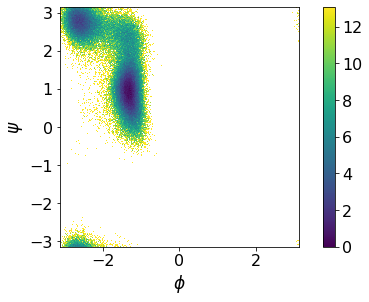

In [6]:
alanine_exp_20ns.ramachandran_plot(rotate=True, bins=300)

Debug: default clustering None, num default clusters None, k 100


initialize kmeans++ centers:   0%|          | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|          | 0/150 [00:00<?, ?it/s]

estimating MaximumLikelihoodMSM:   0%|          | 0/11 [00:00<?, ?it/s]

2.0 fs <class 'openmm.unit.quantity.Quantity'>
[8.11352732e-05 6.41684661e-05 8.55387439e-05 1.60401538e-04
 1.49677969e-04 1.38629254e-04 1.02924583e-04 1.22532895e-04
 7.41332758e-05 1.04443283e-04 1.14126232e-04 1.12970664e-04
 7.83783727e-05 7.67347996e-05 7.99362245e-05 7.62447809e-05
 1.05462497e-04 8.73230614e-05 1.02126617e-04 1.01742744e-04
 8.53702042e-05 7.76848808e-05 7.56416287e-05 8.26705359e-05
 7.50821583e-05 6.33385866e-05 5.82088928e-05 6.69717208e-05
 7.39941762e-05 6.18134281e-05 5.81214728e-05 5.85262102e-05
 7.36110368e-05 6.19886342e-05 6.18950201e-05 6.04131722e-05
 6.54381952e-05 7.51970767e-05 7.27373019e-05 6.63972719e-05
 7.75427520e-05 7.19781253e-05 6.44514224e-05 5.63610602e-05
 5.87869278e-05 5.89197441e-05 5.45688682e-05 5.60313406e-05
 5.77963141e-05 5.07455290e-05 5.84549726e-05 5.49412191e-05
 5.83437964e-05 5.67081744e-05 5.25517720e-05 6.39790728e-05
 6.42045910e-05 5.93512772e-05 5.89827237e-05 6.17033858e-05
 6.21087044e-05 6.64208861e-05 6.20647

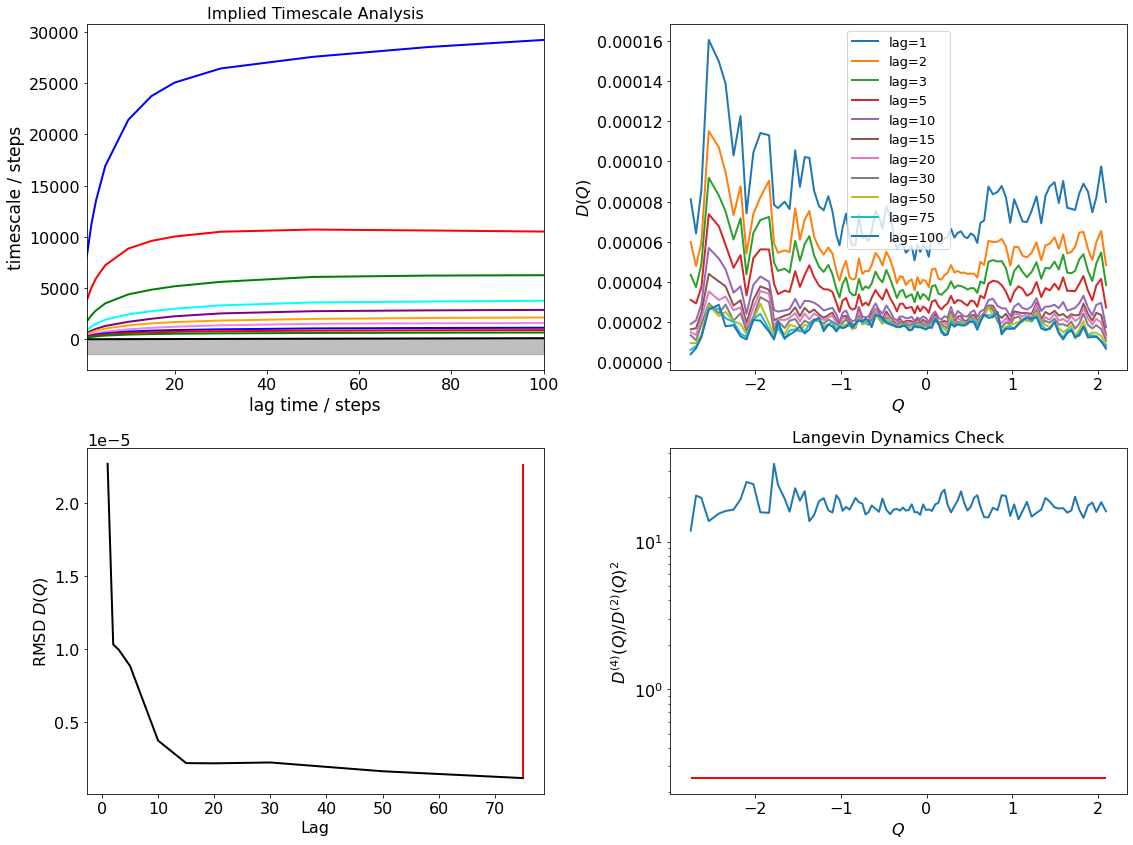

20.0 fs <class 'openmm.unit.quantity.Quantity'>
[1.90739076e-05 2.09096435e-05 2.89307449e-05 5.69056325e-05
 5.16576423e-05 4.63290609e-05 3.46465268e-05 3.78366506e-05
 2.41841039e-05 3.86342645e-05 4.27288055e-05 4.00926177e-05
 2.60105589e-05 2.52519914e-05 2.58360444e-05 2.64736993e-05
 3.16013581e-05 2.68563574e-05 3.06471655e-05 3.04575554e-05
 2.97081723e-05 2.80922001e-05 2.58024477e-05 2.65674956e-05
 2.71294900e-05 2.38755187e-05 1.97644410e-05 2.46701413e-05
 2.58268326e-05 2.18164820e-05 2.04245182e-05 2.10984185e-05
 2.76121813e-05 2.27098548e-05 2.24855027e-05 2.28700580e-05
 2.59574880e-05 2.93220671e-05 2.60791967e-05 2.42251634e-05
 2.82919436e-05 2.54167306e-05 2.20052144e-05 2.07615762e-05
 2.28217491e-05 2.27592453e-05 2.19394504e-05 2.20703539e-05
 2.27047927e-05 2.05713340e-05 2.23188718e-05 2.14467546e-05
 2.28338244e-05 2.20292596e-05 2.01181538e-05 2.34604783e-05
 2.53138623e-05 2.22722637e-05 2.12562119e-05 2.29698432e-05
 2.22507285e-05 2.76147546e-05 2.2474

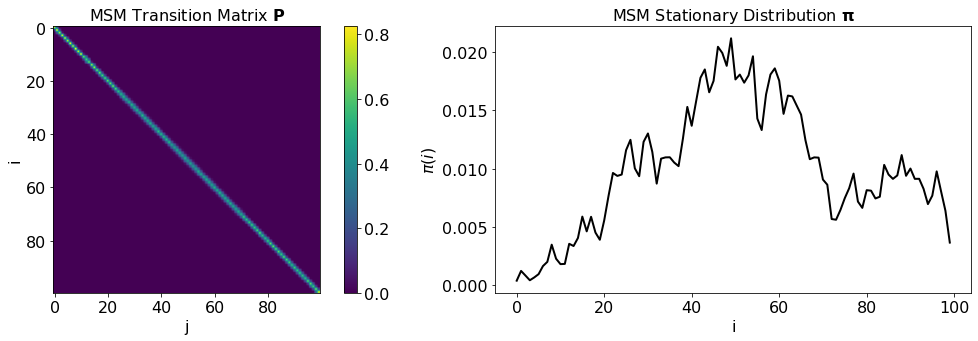

Free energy profile suggests 5 minima.
Minima  (-2.683, 5.699)
Minima  (-2.132, 4.524)
Minima  (-1.782, 4.598)
Minima  (-0.154, 0.18)
Minima  (1.524, 2.73)


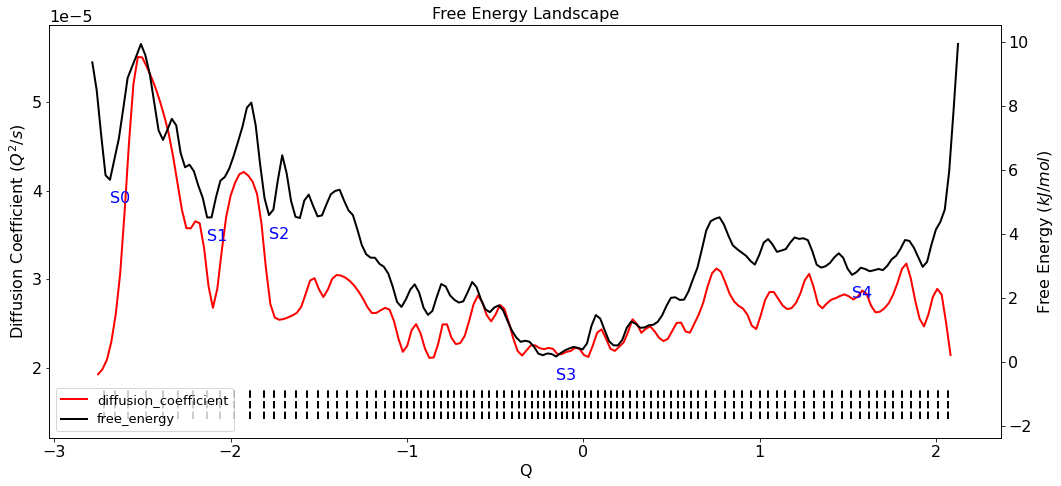

Kramer's Rates
-------------------------
S0 --> S1 : 3.416160e-04
S0 --> S2 : 1.153021e-04
S0 --> S3 : 1.396070e-05
S0 --> S4 : 2.952339e-06
S1 --> S0 : 1.667038e-04
S1 --> S2 : 4.539439e-04
S1 --> S3 : 2.118198e-05
S1 --> S4 : 3.351245e-06
S2 --> S0 : 5.900390e-05
S2 --> S1 : 6.929393e-04
S2 --> S3 : 2.523991e-05
S2 --> S4 : 3.546807e-06
S3 --> S0 : 2.618197e-06
S3 --> S1 : 5.094989e-06
S3 --> S2 : 8.987256e-06
S3 --> S4 : 1.024108e-05
S4 --> S0 : 1.172851e-06
S4 --> S1 : 2.113905e-06
S4 --> S2 : 3.347179e-06
S4 --> S3 : 2.621529e-05
-------------------------


In [7]:
alanine_exp_20ns.analyse_VAMP(dimension=1, lag = 10, sigmaD = 0.02, sigmaF = 0.02)

In [7]:
pdb_file = '../data/alanine.pdb'
trajectory = '../data/outputs/alanine_1us/trajectory.dcd'
dihedral_pickle_file = '../data/outputs/alanine_1us/alanine_1us_dihedral_traj.pickle'
temperature = 300
duration = "987.036ns" 
savefreq = "1ps"
stepsize = "2fs"
alanine_exp_1us = Experiment(pdb=pdb_file, 
                              trajectory = trajectory,
                              dihedral_pickle_file = dihedral_pickle_file,
                              temperature = temperature,
                              duration = duration,
                              savefreq = savefreq,
                              stepsize = stepsize
                              )

/home/dominic/miniconda3/envs/diffusion/lib/python3.9/site-packages/pyemma/coordinates/data/featurization/featurizer.py:895: UserWarning: You have not selected any features. Returning plain coordinates.
  warnings.warn("You have not selected any features. Returning plain coordinates.")


In [8]:
alanine_exp_1us.compute_PCA(dim = 3, stride=1)
alanine_exp_1us.compute_TICA(dim = 3, lag=1, stride=1)
alanine_exp_1us.compute_VAMP(dim = 3, lag=1, stride=1)
alanine_exp_1us.compute_DMAP(stride=50)

Computed PCA in 0.438s.
Computed TICA in 1.423s.
Computed VAMP in 1.111s.
Computed DMAP in 35.854s.


28 NaNs detected, removing rows with NaNs.


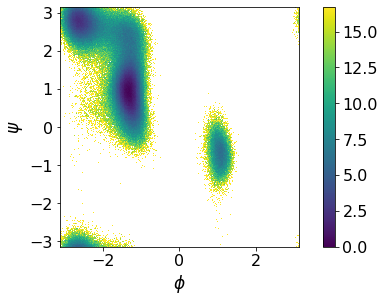

In [10]:
alanine_exp_1us.ramachandran_plot(rotate=False, bins=300)

In [9]:
alanine_exp_20ns.compute_DMAP(stride=5)
alanine_exp_1us.compute_DMAP(stride=25)

Computed DMAP in 115.837s.
Computed DMAP in 129.883s.


In [10]:
alanine_exp_20ns.compute_DMAP(stride=1)
alanine_exp_1us.compute_DMAP(stride=5)

Computed DMAP in 1797.133s.
Computed DMAP in 2514.815s.


In [11]:
dill.dump(alanine_exp_20ns, file=open("alanine_exp_20ns.pickle", "wb"))
dill.dump(alanine_exp_1us, file=open("alanine_exp_1us.pickle", "wb"))

In [17]:
print(len(alanine_exp_1us.DMAP.dmap))

197408
